# Association Rule Mining (ARM)

## Introduction

In [90]:
import nltk
import string
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from apyori import apriori
import networkx as nx 


In [92]:
import requests
import json

# Base URL for the API endpoint
url = 'https://newsapi.org/v2/everything'

# Set all query parameters in a dictionary
params = {
    'q': 'electric-vehicles',  # Updated query
    'from': '2023-11-03',      # Starting date
    'sortBy': 'publishedAt',   # Sorting criterion
    'apiKey': '481b1e4a75874d2f9a23e3329031364c'  
}

# Make the GET request with the URL and parameters
response = requests.get(url, params=params)

# Convert the response to JSON format
json_data = response.json()

# Print the JSON response
print(json_data)

# Save the results in a JSON file
with open('electric_vehicles_news_data.json', 'w') as json_file:
    json.dump(json_data, json_file, indent=4)

print("Data saved in electric_vehicles_news_data.json")

{'status': 'ok', 'totalResults': 6310, 'articles': [{'source': {'id': None, 'name': 'Americanthinker.com'}, 'author': None, 'title': "Joe, we can't sell them", 'description': "How is that electric vehicle promotion going?\xa0 Well, the car dealers can't sell them.\xa0 They sent President Biden a letter calling for a change in strategy, as my old marketing professor used to say.\xa0This is\xa0the story:\r\n\r\n\r\nNea...", 'url': 'https://www.americanthinker.com/blog/2023/12/joe_we_cant_sell_them.html', 'urlToImage': 'https://www.americanthinker.com/images/bucket/2023-12/250507.jpg', 'publishedAt': '2023-12-02T06:00:00Z', 'content': "How is that electric vehicle promotion going?\xa0 Well, the car dealers can't sell them.\xa0 They sent President Biden a letter calling for a change in strategy, as my old marketing professor used to say.\xa0… [+1566 chars]"}, {'source': {'id': None, 'name': 'Feber.se'}, 'author': 'Frode Wikesjö', 'title': 'En släpptrailer för SteamWorld Build', 'descriptio

In [93]:
import pandas as pd
import json

# Read the JSON file
file_path = 'electric_vehicles_news_data.json'
with open(file_path, 'r') as file:
    json_data = json.load(file)

# Extracting articles from the JSON data
# Assuming the articles are nested under a key, likely "articles"
articles = json_data['articles'] if 'articles' in json_data else json_data

# Extracting data from each article
df_list = []
for article in articles:
    row = {
        'source': article['source']['name'] if 'source' in article and 'name' in article['source'] else None,
        'author': article.get('author'),
        'title': article.get('title'),
        'description': article.get('description'),
        'url': article.get('url'),
        'urlToImage': article.get('urlToImage'),
        'publishedAt': article.get('publishedAt'),
        'content': article.get('content')
    }
    df_list.append(row)

# Converting the list of dictionaries to a DataFrame
df = pd.DataFrame(df_list)

# Display the first few rows of the DataFrame
print(df.head())


                source                                             author  \
0  Americanthinker.com                                               None   
1             Feber.se                                      Frode Wikesjö   
2         Setopati.com  Prasanna Aryal :: A tripartite approach to com...   
3     fox26houston.com                                          Tom Zizka   
4        CleanTechnica                                     Zachary Shahan   

                                               title  \
0                            Joe, we can't sell them   
1               En släpptrailer för SteamWorld Build   
2  A tripartite approach to combat climate change...   
3  Most Texans unwilling to buy an electric vehic...   
4  NIO Sales Up 33.1%, Gets Geely in Another Batt...   

                                         description  \
0  How is that electric vehicle promotion going? ...   
1  Spelet släpptes i går\n\n\n\n\n\n\n\n\n\n\nUnd...   
2  In the face of global climate

In [94]:
import pandas as pd

# Extracting the 'description' column and joining all rows into one string
joined_description = ' '.join(df['description'].dropna())

# Saving the joined description to a text file
with open('description.txt', 'w', encoding='utf-8') as file:
    file.write(joined_description)

print("The descriptions have been successfully joined and saved to 'description.txt'")

The descriptions have been successfully joined and saved to 'description.txt'


In [95]:
import os
import string
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

# User parameters
input_path = 'description.txt'
compute_sentiment = True
sentiment = []  # Average sentiment of each chunk of text
ave_window_size = 5 # Size of scanning window for moving average

# Output file
output = 'transactions.txt'
if os.path.exists(output): os.remove(output)

# Initialize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
sia = SentimentIntensityAnalyzer()

# Add more stopwords
stopwords = stopwords.words('english')
add = ['mr', 'mrs', 'wa', 'dr', 'said', 'back', 'could', 'one', 'looked', 'like', 'know', 'around', 'dont', 'a', 'the', 'is', 'are']
stopwords.extend(add)

def read_and_clean(path, START=0, STOP=None):
    global sentiment

    with open(path) as file:
        text = file.read()

    text = text.replace("'", "")  # wasn't --> wasnt
    lines = text.splitlines()
    lines = lines[START:STOP] if STOP else lines[START:]
    text = ' '.join(lines)

    text = ''.join(filter(lambda x: x in string.printable, text))

    sentences = nltk.tokenize.sent_tokenize(text)
    print("NUMBER OF SENTENCES FOUND:", len(sentences))

    keep = '0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
    new_sentences = []
    vocabulary = []

    for sentence in sentences:
        new_sentence = ''
        words = nltk.word_tokenize(sentence)

        for word in words:
            word = word.lower()  # Convert to lowercase first
            word = ''.join(char for char in word if char in keep)
            new_word = lemmatizer.lemmatize(word)

            if new_word not in stopwords and len(new_word) > 0:
                new_sentence += ',' + new_word if new_sentence else new_word
                if new_word not in vocabulary:
                    vocabulary.append(new_word)

        new_sentences.append(new_sentence.split(","))

        if compute_sentiment:
            sentiment_scores = sia.polarity_scores(sentence)
            sentiment.append((sentiment_scores['pos'], sentiment_scores['neg'], sentiment_scores['neu'], sentiment_scores['compound']))

        if len(new_sentence.split(',')) > 2:
            with open(output, "a") as f:
                f.write(new_sentence + "\n")

    sentiment = np.array(sentiment)
    if sentiment.size > 0:
        print("TOTAL AVERAGE SENTIMENT:", np.mean(sentiment, axis=0))
    else:
        print("TOTAL AVERAGE SENTIMENT: No sentiment data available")
    print("VOCAB LENGTH", len(vocabulary))
    return new_sentences

transactions = read_and_clean(input_path)
print(transactions[:5])


NUMBER OF SENTENCES FOUND: 108
TOTAL AVERAGE SENTIMENT: [0.06372222 0.03193519 0.90435185 0.17532407]
VOCAB LENGTH 1238
[['electric', 'vehicle', 'promotion', 'going'], ['well', 'car', 'dealer', 'cant', 'sell'], ['sent', 'president', 'biden', 'letter', 'calling', 'change', 'strategy', 'old', 'marketing', 'professor', 'used', 'saythis', 'isthe', 'story', 'nea', 'spelet', 'slpptes', 'gr', 'grdagen', 'slpptes', 'det', 'svenskutvecklade', 'spelet', 'steamworld', 'build', 'till', 'window', 'xbox', 'xbox', 'game', 'pas', 'och', 'playstation'], ['spelet', 'r', 'det', 'senaste', 'tillskottet', 'den', 'uppskattade', 'steamworldserien', 'man', 'tidigare', 'har', 'kunnat', 'hitta', 'face', 'global', 'climate', 'challenge', 'nepal', 'ha', 'opportunity', 'become', 'beacon', 'change', 'showcasing', 'united', 'effort', 'level', 'government', 'drive', 'transformation', 'towarda', 'sustainable', 'ecofriendly', 'future', 'group', 'thousand', 'car', 'dealer', 'asked', 'white', 'house', 'week', 'tap', 'bra

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/isfarbaset/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/isfarbaset/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/isfarbaset/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [96]:
# see what the sentiment tuple looks like
sentiment

array([[ 0.    ,  0.    ,  1.    ,  0.    ],
       [ 0.259 ,  0.    ,  0.741 ,  0.2732],
       [ 0.    ,  0.    ,  1.    ,  0.    ],
       [ 0.086 ,  0.02  ,  0.894 ,  0.6486],
       [ 0.    ,  0.    ,  1.    ,  0.    ],
       [ 0.    ,  0.    ,  1.    ,  0.    ],
       [ 0.201 ,  0.    ,  0.799 ,  0.8602],
       [ 0.136 ,  0.023 ,  0.841 ,  0.7906],
       [ 0.    ,  0.    ,  1.    ,  0.    ],
       [ 0.043 ,  0.    ,  0.957 ,  0.25  ],
       [ 0.    ,  0.    ,  1.    ,  0.    ],
       [ 0.181 ,  0.131 ,  0.688 ,  0.2023],
       [ 0.    ,  0.    ,  1.    ,  0.    ],
       [ 0.    ,  0.094 ,  0.906 , -0.4588],
       [ 0.    ,  0.19  ,  0.81  , -0.2755],
       [ 0.163 ,  0.052 ,  0.785 ,  0.6597],
       [ 0.    ,  0.13  ,  0.87  , -0.4576],
       [ 0.182 ,  0.    ,  0.818 ,  0.836 ],
       [ 0.122 ,  0.138 ,  0.741 , -0.0772],
       [ 0.    ,  0.    ,  1.    ,  0.    ],
       [ 0.    ,  0.    ,  1.    ,  0.    ],
       [ 0.    ,  0.    ,  1.    ,  0.    ],
       [ 0

In [97]:
# Assign positive and negetive sentiments
positive_sentiment = [score[1] for score in sentiment]
negative_sentiment = [score[2] for score in sentiment]

In [98]:
def moving_ave(y, w=100):
    # Compute the moving average of a signal y
    # code ref:https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
    return np.convolve(y, np.ones(w)/w, mode='valid')

In [99]:
positive_moving_avg = moving_ave(positive_sentiment, ave_window_size)
negative_moving_avg = moving_ave(negative_sentiment, ave_window_size)

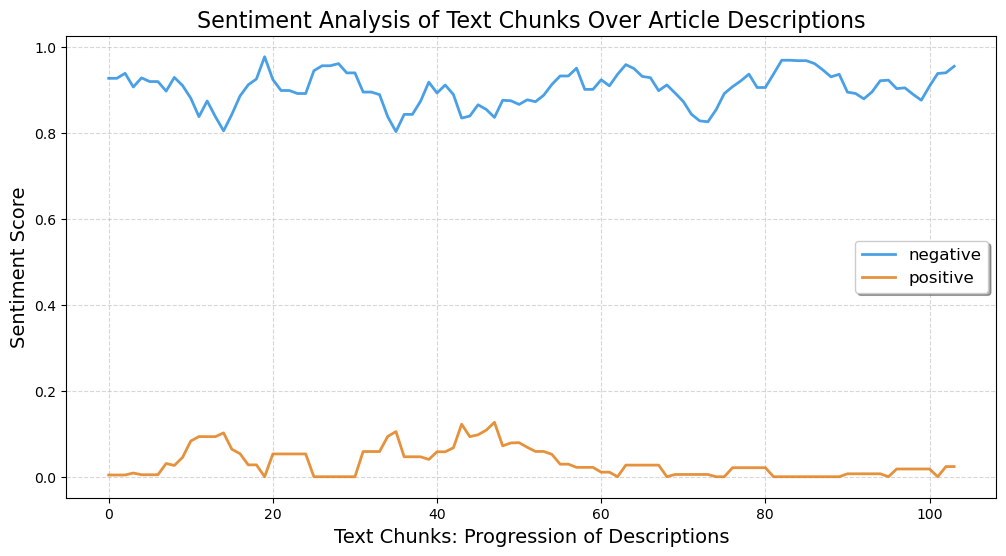

In [100]:
import matplotlib.pyplot as plt

# Plot the results with improved aesthetics
plt.figure(figsize=(12, 6))  # Larger figure size for better visibility
plt.plot(negative_moving_avg, label='negative', color='#1d89e0', linewidth=2, alpha=0.8)
plt.plot(positive_moving_avg, label='positive', color='#e0760b', linewidth=2, alpha=0.8)
plt.xlabel('Text Chunks: Progression of Descriptions', fontsize=14)  # Larger font size for axes labels
plt.ylabel('Sentiment Score', fontsize=14)  # Larger font size for axes labels
plt.title('Sentiment Analysis of Text Chunks Over Article Descriptions', fontsize=16)  # Adding a title
plt.legend(loc='best', fontsize=12, frameon=True, shadow=True)  # Improved legend with frame and shadow
plt.grid(True, linestyle='--', alpha=0.5)  # Adding a grid for readability
plt.show()


In [101]:
def reformat_results(results):

    #CLEAN-UP RESULTS 
    keep=[]
    for i in range(0,len(results)):
        # print("=====================================")
        # print(results[i])
        # print(len(list(results[i])))
        for j in range(0,len(list(results[i]))):
            # print(results)
            if(j>1):
                for k in range(0,len(list(results[i][j]))):
                    if(len(results[i][j][k][0])!=0):
                        #print(len(results[i][j][k][0]),results[i][j][k][0])
                        rhs=list(results[i][j][k][0])
                        lhs=list(results[i][j][k][1])
                        conf=float(results[i][j][k][2])
                        lift=float(results[i][j][k][3])
                        keep.append([rhs,lhs,supp,conf,supp*conf,lift])
                        # keep.append()
            if(j==1):
                supp=results[i][j]

    return pd.DataFrame(keep, columns =["rhs","lhs","supp","conf","supp x conf","lift"])

In [102]:
def convert_to_network(df):
    print(df)

    #BUILD GRAPH
    G = nx.DiGraph()  # DIRECTED
    for row in df.iterrows():
        # for column in df.columns:
        lhs="_".join(row[1][0])
        rhs="_".join(row[1][1])
        conf=row[1][3]; #print(conf)
        if(lhs not in G.nodes): 
            G.add_node(lhs)
        if(rhs not in G.nodes): 
            G.add_node(rhs)

        edge=(lhs,rhs)
        if edge not in G.edges:
            G.add_edge(lhs, rhs, weight=conf)

    # print(G.nodes)
    # print(G.edges)
    return G


In [103]:
def plot_network(G):
    #SPECIFIY X-Y POSITIONS FOR PLOTTING
    pos=nx.random_layout(G)

    #GENERATE PLOT
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 15)

    #assign colors based on attributes
    weights_e 	= [G[u][v]['weight'] for u,v in G.edges()]

    #SAMPLE CMAP FOR COLORS 
    cmap=plt.cm.get_cmap('Blues')
    colors_e 	= [cmap(G[u][v]['weight']*10) for u,v in G.edges()]

    #PLOT
    nx.draw(
    G,
    edgecolors="black",
    edge_color=colors_e,
    node_size=2000,
    linewidths=2,
    font_size=8,
    font_color="white",
    font_weight="bold",
    width=weights_e,
    with_labels=True,
    pos=pos,
    ax=ax
    )
    ax.set(title='EV Articles')
    plt.show()

In [104]:
print("Transactions:",pd.DataFrame(transactions))
results = list(apriori(transactions, min_support=0.1, min_confidence=0.0, min_lift=0, min_length=1))     #RUN APRIORI ALGORITHM
pd_results=reformat_results(results)
print("Results\n",pd_results)
G=convert_to_network(pd_results)

Transactions:                0          1           2           3            4   \
0        electric    vehicle   promotion       going         None   
1            well        car      dealer        cant         sell   
2            sent  president       biden      letter      calling   
3          spelet          r         det     senaste  tillskottet   
4             nio  continues        grow       china         None   
..            ...        ...         ...         ...          ...   
103  increasingly   prevalen  washington     general        motor   
104           due         gm    historic  investment            u   
105        taking     center       stage    campaign         mini   
106        little        dog        mini      cooper        giant   
107        vrlget        kan         man        vlja          att   

              5            6                  7           8            9   \
0           None         None               None        None         None   
1  

/var/folders/w3/pq9m5d810bz24_jz2zl3s6pr0000gn/T/ipykernel_27246/183469868.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues')


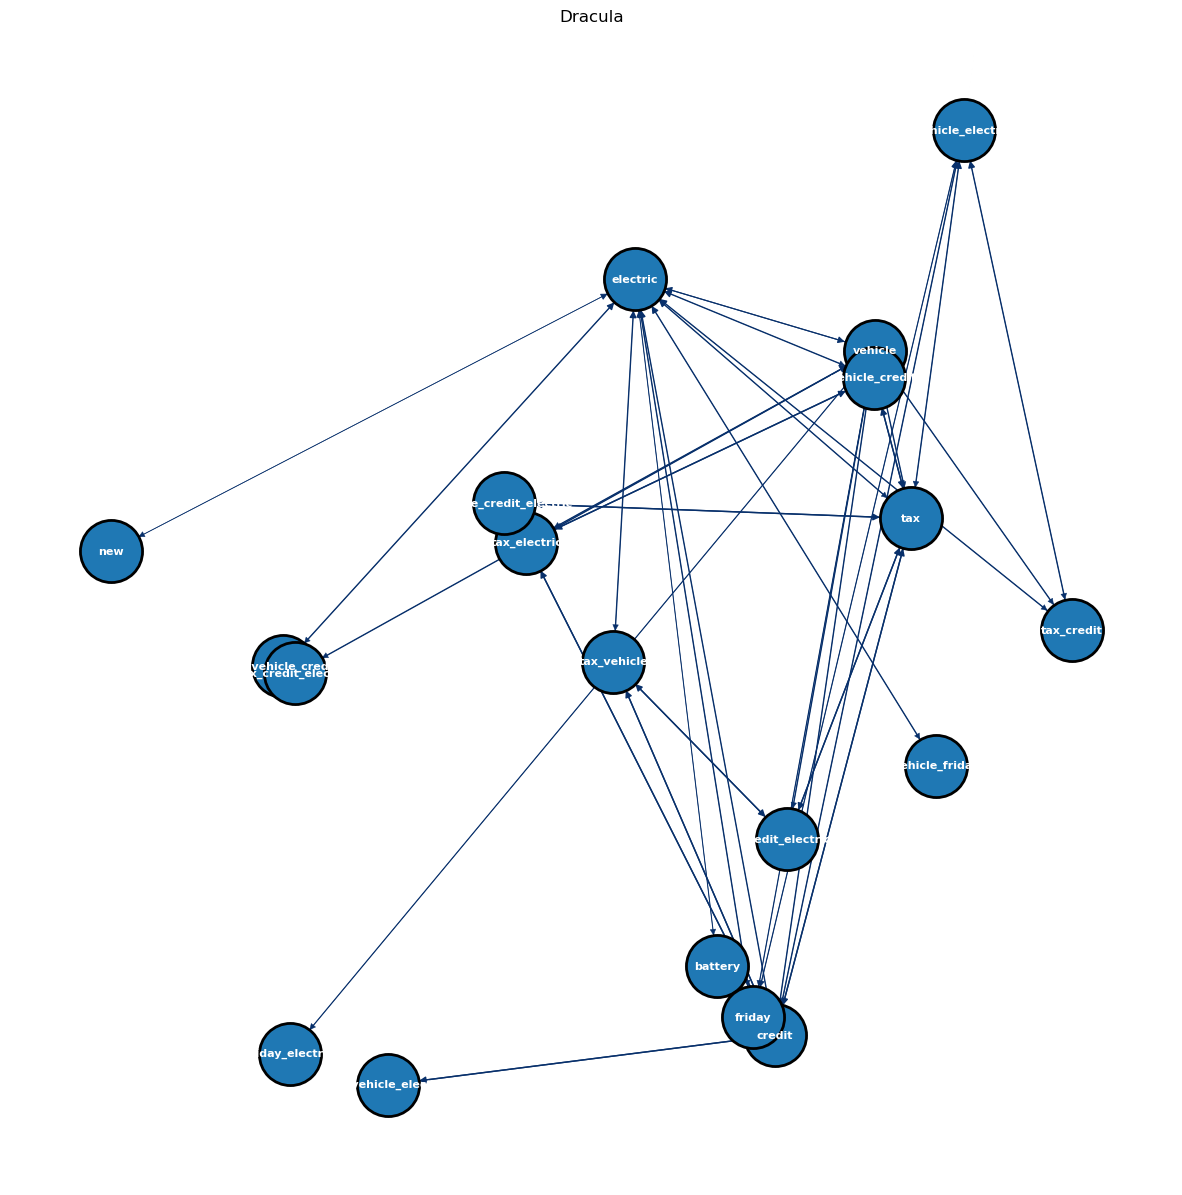

In [105]:
plot_network(G)